# Imports

In [1]:
import sys, os

import s3fs
import xarray as xr

import progressbar

import warnings

from math import sqrt
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt
import imageio

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities as utils

import boto3

import pickle


import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [3]:
start_year = 2007.
end_year = 2015.

grid_size = 50000.

grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

dh_mod_obs_sigma_multiplier = 75.
dhThresholdMax = np.nan #-5

debug_plots = True

start_year_string = '{:4d}'.format(int(start_year))[2:]
end_year_string   = '{:4d}'.format(int(end_year)  )[2:]

# For saving the results ...
run_name = 'thickness_case_'
run_description = 'start_year = {:4.0f}; end_year = {:4.0f}; '.format(start_year, end_year) + \
                  'grid_size = {:8.0f}; dh_mod_obs_sigma_multiplier = {:5.0f}; dhThresholdMax = {:f}'.format(grid_size, dh_mod_obs_sigma_multiplier, dhThresholdMax)


In [4]:
# Load total MAF / GMSL
maf_cmmtt = dict()
maf_ctrl = dict()
gmsl_change_2100 = dict()
gmsl_anomaly_change_2100 = dict()

s3 = s3fs.S3FileSystem(anon=False)
maf_files = s3.glob('dh-gapc/GrIS_committed_SLR/netcdfs/MAF/*cmmtt*MAF.nc')

ensembleIDs = list()
for iFile, maf_file in enumerate(maf_files):
    ensembleID = os.path.basename(maf_file).split('.')[3]
    ensembleIDs.append(ensembleID)
    
    # Read cmmtt MAF netcdf
    with s3.open(maf_file, 'rb') as f:
        maf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = maf_ds['limnsw'].data
        maf_cmmtt[ensembleID] = limnsw
    
    
    # Read ctrl MAF netcdf
    maf_file = maf_file.replace('cmmtt','ctrl')
    
    with s3.open(maf_file, 'rb') as f:
        maf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = maf_ds['limnsw'].data
        maf_ctrl[ensembleID] = limnsw
    
    
    maf_anomaly = maf_cmmtt[ensembleID] - maf_ctrl[ensembleID]
    maf_anomaly_change_2100 = maf_anomaly[-1] - maf_anomaly[1]
    gmsl_anomaly_change_2100[ensembleID] = -(maf_anomaly_change_2100/1e12)/361.8
    
    maf_change_2100 = maf_cmmtt[ensembleID][-1] - maf_cmmtt[ensembleID][0]
    gmsl_change_2100[ensembleID] = -(maf_change_2100/1e12)/361.8


# Read SERAC observations

<h3><font color='red'>NOTE:</font></h3>

Bea suggested using DPS (ALPS) when abs(dh) > 5m and DTS (poly fit) when abs(dh) < 5m because ALPS does a good job at fitting dh in highly dynamic areas and the poly fit does a better job in the places where there's little dynamic dh (because ALPS can actually overfit to errors in these places. Can make this mod in utils.read_SERAC_obs.

In [15]:
# Read dynamic dh from SERAC
dh_dyn_obs = utils.read_SERAC_obs('SERAC/SERACAnnualRates2021JanIGSPres.csv')

# select obs
dh_dyn_obs_selected = utils.select_dh_obs(dh_dyn_obs, startYear=start_year, endYear=end_year, dhThresholdMax=dhThresholdMax)
print('selected number of obs: {:8d}'.format(len(dh_dyn_obs_selected)))


total    number of obs:    53224
selected number of obs:    16136


In [16]:
for d in dh_dyn_obs_selected:
    if d['dh_sigma'] == 0.05:
        d['dh0715'] = d['dh0715'] - 0.8


## Grid the observations

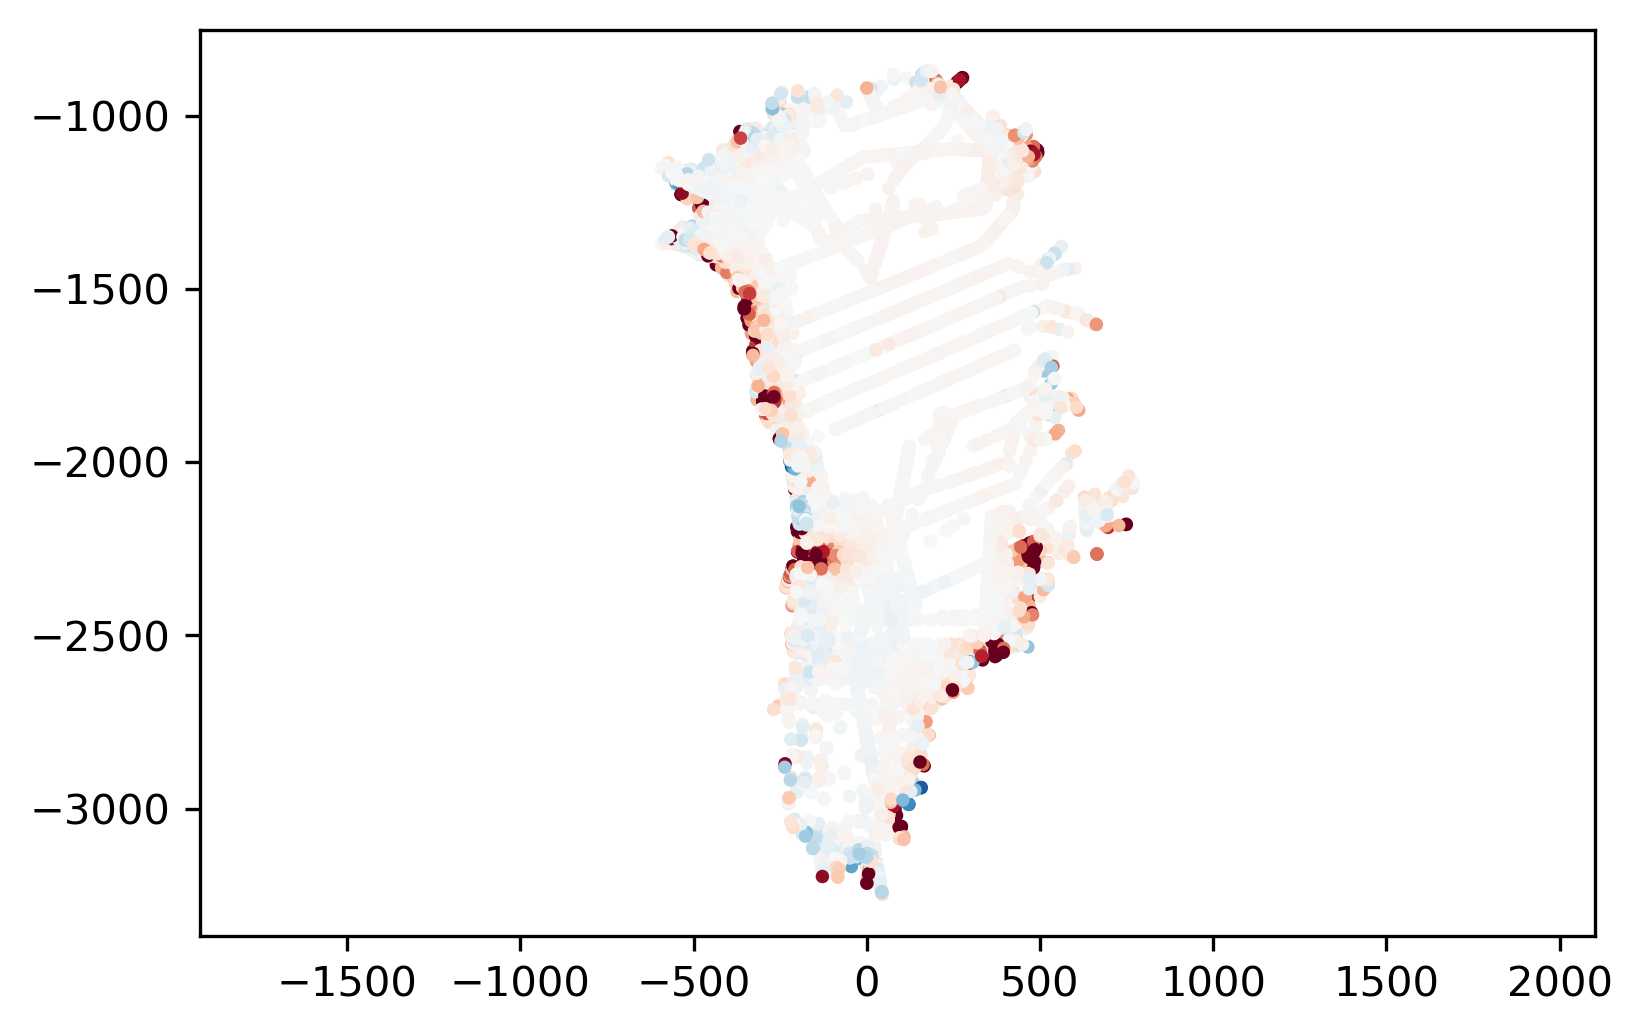

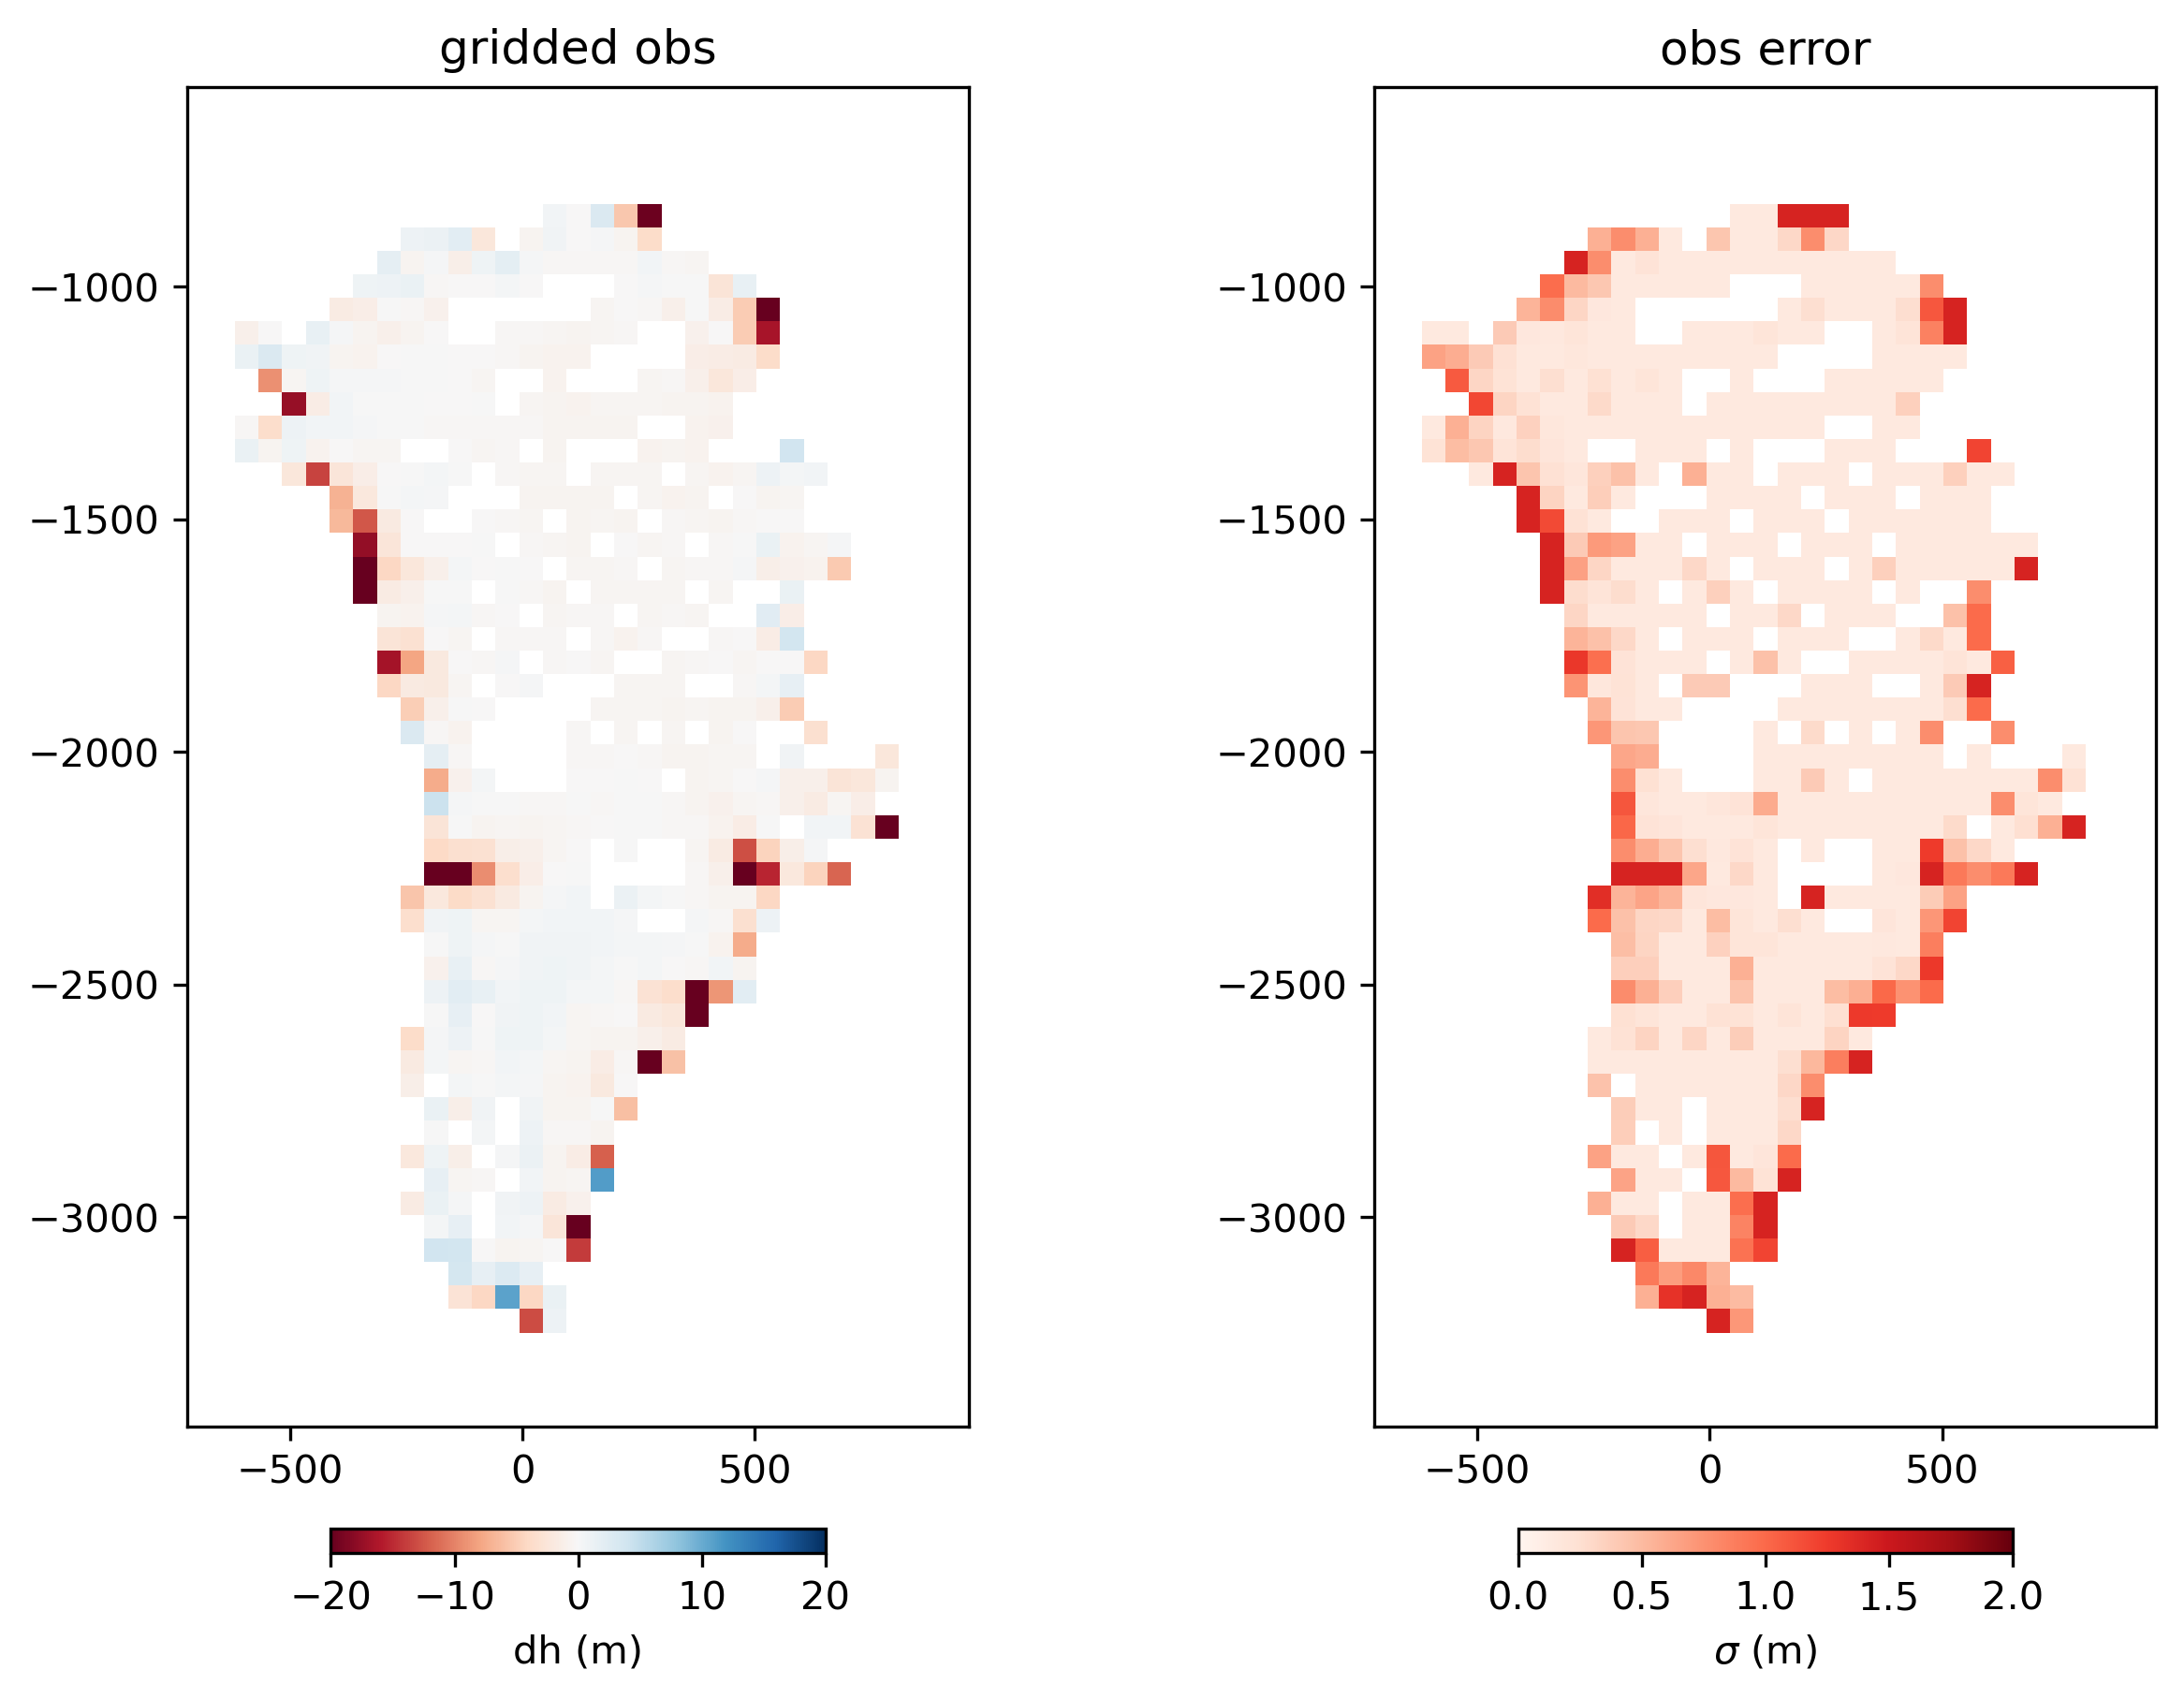

In [17]:
# Setup grid
x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

# Setup another grid at 50 km for plotting purposes
grid_size_plot = 50000.
x_centers_plot = np.arange(grid_extent[0]+grid_size_plot/2, grid_extent[1]-grid_size_plot/2, grid_size_plot)
y_centers_plot = np.arange(grid_extent[2]+grid_size_plot/2, grid_extent[3]-grid_size_plot/2, grid_size_plot)


# Grid the observations
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    dh_obs_grid, dh_obs_sigma_grid = utils.grid_obs_dh(x_centers, y_centers, grid_size, grid_size, dh_dyn_obs_selected, \
                                                                                         startYear=start_year, endYear=end_year)
    dh_obs_grid_plot, dh_obs_sigma_grid_plot = utils.grid_obs_dh( \
                                    x_centers_plot, y_centers_plot, grid_size_plot, grid_size_plot, \
                                    dh_dyn_obs_selected, startYear=start_year, endYear=end_year)
    
# Plot
if debug_plots:
    fig, ax = plt.subplots(dpi=300)
    
    im_dh = ax.scatter([d['x']/1000 for d in dh_dyn_obs_selected], \
                       [d['y']/1000 for d in dh_dyn_obs_selected], \
                       c=[d['dh' + start_year_string + end_year_string] for d in dh_dyn_obs_selected], \
                       s=5., cmap='RdBu', vmin=-20, vmax=20)
    ax.axis('equal')
    
fig, ax = plt.subplots(1,2,figsize=(10,8),dpi=300)
im_dh = ax[0].imshow(dh_obs_grid_plot, extent=[e/1000. for e in grid_extent], \
           cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
           aspect='auto')

im_er = ax[1].imshow(dh_obs_sigma_grid_plot, extent=[e/1000. for e in grid_extent], \
           cmap='Reds', vmin=0, vmax=2, origin='lower', \
           aspect='auto')

cb = fig.colorbar(im_dh, orientation='horizontal', ax=ax[0], pad=0.06, shrink=0.5)
cb.set_label('dh (m)')
cb = fig.colorbar(im_er, orientation='horizontal', ax=ax[1], pad=0.06, shrink=0.5)
cb.set_label('$\sigma$ (m)')

ax[0].set_title('gridded obs')
ax[1].set_title('obs error')

x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

#fig.savefig('plots/SERAC_obs.png', bbox_inches='tight')


# Calculate residuals

<h3><font color='red'>NOTE:</font></h3> This can take a few minutes to run ...

In [18]:
# Find all model files
s3 = s3fs.S3FileSystem(anon=False)
names = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom/*6079.nc.zarr')
#names = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom_old/*6079.nc.zarr')
#names = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom_new/*.nc.zarr')

# DEBUG
#names = names[:4]

# Loop through model files and return statistics and scores
with tqdm_joblib(tqdm(desc='Looping through models', total=len(names))) as progress_bar:
    res = Parallel(n_jobs=4)(delayed(utils.grid_models_and_calculate_residuals) \
                             (name, x_centers, y_centers, grid_size, \
                              dh_obs_grid, dh_obs_sigma_grid, dh_mod_obs_sigma_multiplier) for name in names)


s_j = np.array([r[0] for r in res])
w_j = s_j / np.sum(s_j)


Looping through models: 100%|██████████| 137/137 [03:17<00:00,  1.44s/it]


### Intermediate checks

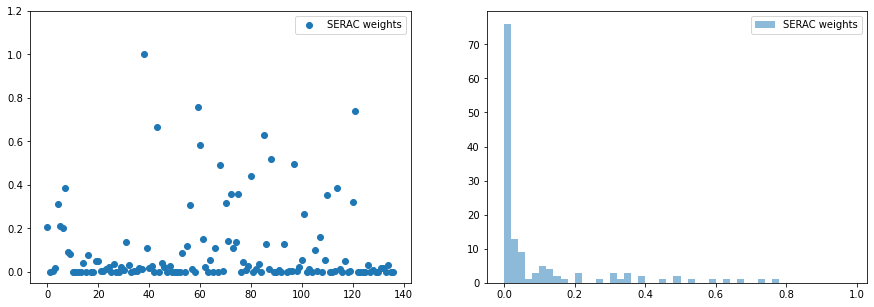

In [19]:
bins = np.arange(0,1.0,0.02)


w_j_scaled = w_j / np.max(w_j)


# Plot the values of the weights
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(w_j_scaled, 'o', label='SERAC weights')
ax[0].set_ylim(-0.05, 1.20)
ax[0].legend()
ax[1].hist(w_j_scaled, bins=bins, alpha=0.5, label='SERAC weights')
ax[1].legend()


## Plot highest/lowest weighted ensemble members from SERAC calibration

In [ ]:
# Plot the observations with the ensemble members with the highest and lowest weights
w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
name_highest_weight = names[w_j_sorted_idx[-1]]
name_lowest_weight  = names[w_j_sorted_idx[ 0]]


for mod_name in (name_highest_weight, name_lowest_weight):
    dh_mod_grid = utils.grid_mod_dh \
                                (mod_name, x_centers, y_centers, grid_size, grid_size) \


    fig, ax = plt.subplots(1,4,figsize=(16,8))

    im_dh = ax[0].imshow(dh_obs_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    im_dh = ax[1].imshow(dh_mod_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    residuals = dh_mod_grid - dh_obs_grid
    im_dh = ax[2].imshow(residuals, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[0], pad=0.06)
    cb.set_label('dh (m)')
    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[1], pad=0.06)
    cb.set_label('dh (m)')
    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[2], pad=0.06)
    cb.set_label('dh (m)')
    
    residuals = residuals.flatten()
    residuals = residuals[~np.isnan(residuals)]
    ax[3].hist(residuals, bins=50)
    
    fig.suptitle(mod_name)
    ax[0].set_title('gridded obs')
    ax[1].set_title('gridded mod')
    ax[2].set_title('residuals')
    

In [ ]:
# Plot the observations with the ensemble members with the highest and lowest weights
w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
name_highest_weight = names[w_j_sorted_idx[-1]]
name_lowest_weight  = names[w_j_sorted_idx[ 0]]


for mod_name in (name_highest_weight, name_lowest_weight):
    dh_mod_grid = utils.grid_mod_dh \
                                (mod_name, x_centers, y_centers, grid_size, grid_size) \


    fig, ax = plt.subplots(1,4,figsize=(16,8))

    im_dh = ax[0].imshow(dh_obs_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    im_dh = ax[1].imshow(dh_mod_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    residuals = dh_mod_grid - dh_obs_grid
    im_dh = ax[2].imshow(residuals, extent=[e/1000. for e in grid_extent], \
                   cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                   aspect='auto')

    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[0], pad=0.06)
    cb.set_label('dh (m)')
    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[1], pad=0.06)
    cb.set_label('dh (m)')
    cb = plt.colorbar(im_dh, orientation='horizontal', ax=ax[2], pad=0.06)
    cb.set_label('dh (m)')
    
    residuals = residuals.flatten()
    residuals = residuals[~np.isnan(residuals)]
    ax[3].hist(residuals, bins=50)
    
    fig.suptitle(mod_name)
    ax[0].set_title('gridded obs')
    ax[1].set_title('gridded mod')
    ax[2].set_title('residuals')
    

# Save the weights

In [20]:
run_name = 'thickness_case_'
#run_name = 'thickness_case_7_dhdynAnom_old'
#run_name = 'thickness_case_8_dhdynAnom_new'

In [21]:
# Save the weights
if os.path.isdir('results/' + run_name):
    print('WARNING: Results directory with name ' + run_name + ' already exists!')

else:
    os.mkdir('results/' + run_name)

    txt_file = open('results/' + run_name + '/description.txt', 'w')
    txt_file.write(run_description)
    txt_file.close()

    pickle.dump({'s_j': s_j, 'w_j': w_j}, open('results/' + run_name + '/weights.p', 'wb'))
    

# Bayesian calibration

In [22]:
# Select the weights
run_names = [run_name]

w_j_list = list()
for run_name in run_names:
    p = pickle.load(open('results/' + run_name + '/weights.p', 'rb'))
    w_j = p['w_j']
    w_j_list.append(w_j)
    

thickness_case_:  0.0%
prior     :  8.8%


Text(0, 0.5, 'probability')

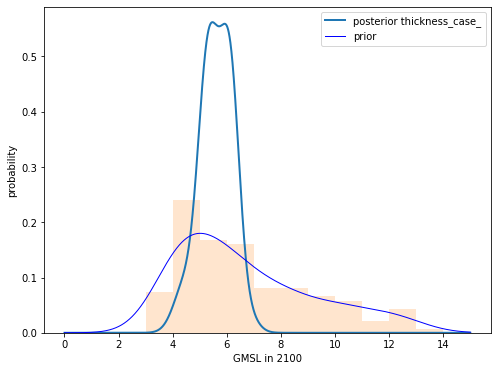

In [23]:
# Select thesholds
gmsl_thresholds = [8] # mm of GMSL rise in 2100


gmsl_anomaly_change_2100_values = list(gmsl_anomaly_change_2100.values())

bins = np.arange(0,16,1)

fig, ax = plt.subplots(figsize=(8,6))

for run_name, w_j in zip(run_names, w_j_list):
    # SERAC weights
    x_kpde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_anomaly_change_2100_values, w_j)

    # estimated density: posterior (SERAC)
    ax.plot(x_kpde, gmsl_posterior, label='posterior ' + run_name, linewidth=2.)

    for gmsl_threshold in gmsl_thresholds:
        idx = np.where(x_kpde > gmsl_threshold)[0][0]
        print('{:10s}: {:4.1f}%'.format(run_name, 100 * gmsl_posterior[idx]))
        
# estimated density: prior
_ = ax.hist(gmsl_anomaly_change_2100_values, density=True, alpha=0.2, bins=bins)
ax.plot(x_kpde, gmsl_prior, label='prior', color='b', linewidth=1.)
idx = np.where(x_kpde > gmsl_threshold)[0][0]
print('{:10s}: {:4.1f}%'.format('prior', 100 * gmsl_prior[idx]))

plt.legend()
plt.xlabel('GMSL in 2100')
plt.ylabel('probability')
